In [1]:
import sys
sys.path.append("../")

from benchmarks.galaxies.dataset_large import get_halo_dataset
from tqdm import tqdm
import numpy as np

# Make sure tf does not hog all the GPU memory
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.experimental.set_visible_devices([], "GPU")

2024-05-15 15:20:24.112989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 15:20:24.113024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 15:20:24.114266: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
features = ['x', 'y', 'z']  # ['x', 'y', 'z', 'Jx', 'Jy', 'Jz', 'vx', 'vy', 'vz', 'M200c']
params = ['Omega_m', 'sigma_8']  # ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
batch_size = 64

dataset, num_total = get_halo_dataset(batch_size=batch_size,  # Batch size
                           num_samples=2000,  # If not None, will only take a subset of the dataset
                           split='train',  # 'train', 'val'
                           standardize=False,  # If True, will standardize the features
                           return_mean_std=False,  # If True, will return (dataset, num_total, mean, std, mean_params, std_params), else (dataset, num_total)
                           seed=42,  # Random seed
                           features=features,  # Features to include
                           params=params  # Parameters to include
                        )

# Print number of samples
print(f"Number of samples: {num_total}")

Number of samples: 2000


In [3]:
iterator = iter(dataset)

x_train, params_train = [], []
for _ in tqdm(range(num_total // batch_size)):
    x, params = next(iterator)
    x_train.append(np.array(x))
    params_train.append(np.array(params))

x_train = np.concatenate(x_train, axis=0)
params_train = np.concatenate(params_train, axis=0)

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:01<00:00, 24.35it/s]


In [4]:
x_train = np.load("../../BNN_SBI/data/set_diffuser_data/train_halos.npy")[..., :3]

import pandas as pd
params_train = pd.read_csv("../../BNN_SBI/data/set_diffuser_data/train_cosmology.csv",)
params_train = params_train[["Omega_m", "sigma_8"]].values

In [5]:
# ! python -m pip install git+https://github.com/cosmodesi/pycorr#egg=pycorr[corrfunc]

In [6]:
# Install as above, to compute 2-point correlation function summaries
from pycorr import TwoPointCorrelationFunction

In [10]:
r_bins = np.linspace(0.5, 150.0, 25)  # Distance in Mpc/h
r_c = 0.5 * (r_bins[1:] + r_bins[:-1])
mu_bins = np.linspace(-1, 1, 201)
box_size = 1000.

tpcf_train = []
for halo in tqdm(x_train):

    tpcf = TwoPointCorrelationFunction(
                "smu",
                edges=(np.array(r_bins), np.array(mu_bins)),
                data_positions1=np.array(halo[:, :3]).T,
                engine="corrfunc",
                n_threads=2,
                boxsize=box_size,
                los="z",
            )(ells=[0])[0]
    
    tpcf_train.append(tpcf)

tpcf_train = np.array(tpcf_train)


  0%|          | 0/1800 [00:00<?, ?it/s]/n/holystore01/LABS/iaifi_lab/Users/smsharma/envs/equivariant/lib/python3.10/site-packages/pycorr/corrfunc.py:148: UserWarning: These arguments are not read: {'n_threads': 2}
  warnings.warn('These arguments are not read: {}'.format(attrs))
100%|██████████| 1800/1800 [01:53<00:00, 15.92it/s]


In [7]:
from models.mlp import MLP
from models.transformer import Transformer
import jax
import jax.numpy as jnp

In [11]:
model = Transformer(task="node", n_outputs=3)
n_batch = 2

rng = jax.random.PRNGKey(0)
out, params = model.init_with_output(rng, x_train[:n_batch])

out.shape

(2, 5000, 3)

In [30]:
model = MLP(feature_sizes=[128, 128, 128, 2])
n_batch = 128

rng = jax.random.PRNGKey(0)
out, params = model.init_with_output(rng, tpcf_train[:n_batch])

out.mean()

Array(-0.81445813, dtype=float32)

In [31]:
import optax
import flax
from flax.training.train_state import TrainState
from functools import partial
from tqdm import trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

# Define train state and replicate across devices
tx = optax.adamw(learning_rate=6e-4, weight_decay=1e-5)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)
pstate = replicate(state)

In [32]:
@partial(jax.pmap, axis_name="batch",)
def train_step(state, x, theta,):
        
    def loss_fn(params):
        out = state.apply_fn(params, x)
        return jnp.mean((out - theta) ** 2)

    # Get loss, grads, and update state
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    
    return new_state, metrics

In [33]:
num_local_devices = jax.local_device_count()
print(f"Number of devices: {num_local_devices}")

Number of devices: 1


In [34]:
n_steps = 5000
n_batch = 64

key = jax.random.PRNGKey(0)

train_loss_list = []
val_loss_list = []

with trange(n_steps) as steps:
    for step in steps:
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, tpcf_train.shape[0], shape=(n_batch,))
        
        tpcf_batch, theta_batch = tpcf_train[idx], params_train[idx]

        # Split batches across devices
        tpcf_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), tpcf_batch)
        theta_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), theta_batch)

        tpcf_batch, theta_batch = map(jnp.array, [tpcf_batch, theta_batch])

        pstate, metrics = train_step(pstate, tpcf_batch, theta_batch)

        train_loss = unreplicate(metrics["loss"])
        steps.set_postfix(loss=train_loss)

        # Append to list along with current step
        train_loss_list.append((step, train_loss))

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:13<00:00, 368.84it/s, loss=0.003126772] 


In [35]:
# # Evaluate on training data
# out = model.apply(unreplicate(pstate).params, tpcf_train[:50])

# # Plot true vs predicted
# import matplotlib.pyplot as plt

# plt.scatter(params_train[:50, 0], out[:, 0])

In [36]:
# Get tpcf on validation set

features = ['x', 'y', 'z']  # ['x', 'y', 'z', 'Jx', 'Jy', 'Jz', 'vx', 'vy', 'vz', 'M200c']
params = ['Omega_m', 'sigma_8']  # ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']

dataset, num_total = get_halo_dataset(batch_size=50,  # Batch size
                            num_samples=250,  # If not None, will only take a subset of the dataset
                            split='val',  # 'train', 'val'
                            standardize=False,  # If True, will standardize the features
                            return_mean_std=False,  # If True, will return (dataset, num_total, mean, std, mean_params, std_params), else (dataset, num_total)
                            seed=42,  # Random seed
                            features=features,  # Features to include
                            params=params  # Parameters to include
                            )

iterator = iter(dataset)

x_val, params_val = [], []
for _ in tqdm(range(num_total // batch_size)):
    x, params = next(iterator)
    x_val.append(np.array(x))
    params_val.append(np.array(params))

x_val = np.concatenate(x_val, axis=0)
params_val = np.concatenate(params_val, axis=0)

# x_val = np.load("../../BNN_SBI/data/set_diffuser_data/test_halos.npy") 

# import pandas as pd
# params_val = pd.read_csv("../../BNN_SBI/data/set_diffuser_data/test_cosmology.csv",)
# params_val = params_val[["Omega_m", "sigma_8"]].values

tpcf_val = []

for halo in tqdm(x_val):
    
        tpcf = TwoPointCorrelationFunction(
                    "smu",
                    edges=(np.array(r_bins), np.array(mu_bins)),
                    data_positions1=np.array(halo[:, :3]).T,
                    engine="corrfunc",
                    n_threads=2,
                    boxsize=box_size,
                    los="z",
                )(ells=[0])[0]
        
        tpcf_val.append(tpcf)

tpcf_val = np.array(tpcf_val)

 28%|██▊       | 42/150 [00:03<00:06, 15.50it/s]

100%|██████████| 150/150 [00:09<00:00, 15.06it/s]


Text(0.5, 1.0, 'sigma_8')

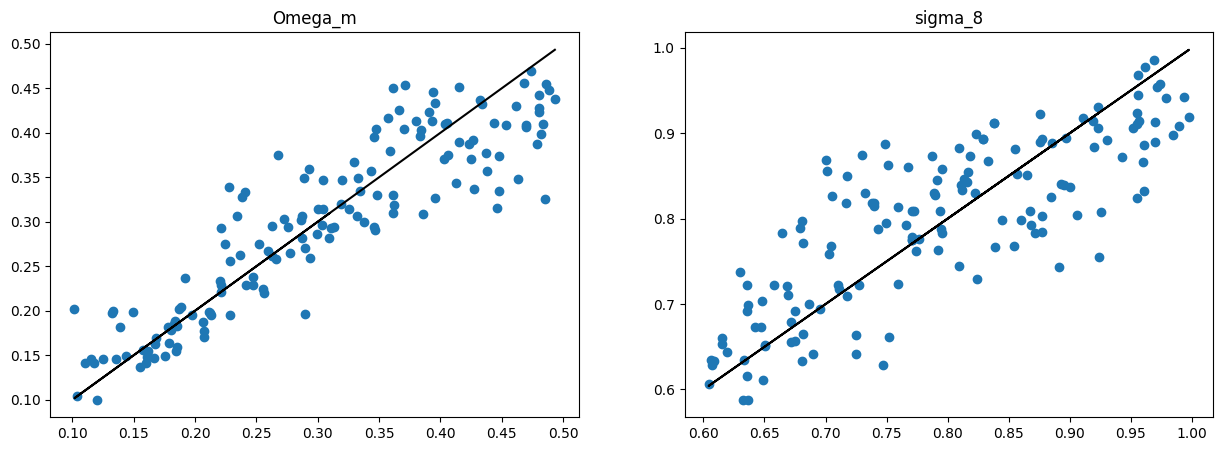

In [49]:
# Plot for the two parameters side by side

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

out = model.apply(unreplicate(pstate).params, tpcf_val)


axs[0].scatter(params_val[:, 0], out[:, 0])
axs[0].plot(params_val[:, 0], params_val[:, 0], color='black')
axs[0].set_title("Omega_m")

axs[1].scatter(params_val[:, 1], out[:, 1])
axs[1].plot(params_val[:, 1], params_val[:, 1], color='black')
axs[1].set_title("sigma_8")